<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-2--online-ad-clicks/02_making_predictions_using_central_limit_theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Making predictions using the central limit theorem

The normal distribution is a bell-shaped curve.The
curve arises naturally from random data sampling due to the central limit theorem. 

Furthermore, the theorem predicts
a narrowing of that curve as the size of each frequency sample goes up. 

In other words, the distribution’s standard deviation should decrease as the sampling size
increases.

The central limit theorem lies at the heart of all classic statistics.

So, we probe the theorem in great detail using the computational power of SciPy. Eventually, we learn how to use the theorem to make predictions from limited data.

##Setup

In [16]:
from collections import defaultdict
import itertools

import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt

In [8]:
# Penalizing centers using the squared distance from the minimum
def squared_distance(value1, value2):
  return (value1 - value2) ** 2

In [9]:
# Penalizing centers using the total sum of squared distances
def sum_of_squared_distances(value, measurements):
  return sum(squared_distance(value, m) for m in measurements)

In [10]:
# Computing California’s sum of squares
def sum_of_squares(data):
  mean = np.mean(data)
  return sum(squared_distance(value, mean) for value in data)

In [11]:
# Computing the variance from mean squared distance
def variance(data):
  mean = np.mean(data)
  return np.mean([squared_distance(value, mean) for value in data])

In [12]:
# Computing the weighted variance using np.average
def weighted_variance(data, weights):
  mean = np.average(data, weights=weights)
  squared_distances = [squared_distance(value, mean) for value in data]
  return np.average(squared_distances, weights=weights)

assert weighted_variance([75, 77], [9, 1]) == np.var(9 * [75] + [77])

##Manipulating the normal distribution

Let’s generate a normal distribution by plotting a histogram of coin-flip samples. Our
input into the histogram will contain 100,000 head-count frequencies. Computing the
frequencies will require us to sample a series of coin flips 100,000 times.

If we use the sample size to divide the sum of values in
the sample, we will compute the observed head-count frequency. Conceptually, this
frequency is equal to simply taking the sample’s mean.

In [4]:
# Computing head-count frequencies from the mean
np.random.seed(0)

sample_size = 10000
sample = np.array([np.random.binomial(1, 0.5) for _ in range(sample_size)])
head_count = sample.sum()

head_count_frequency = head_count / sample_size
# The head-count frequency is identical to the sample mean.
assert head_count_frequency == sample.mean()

Of course, we can compute all 100,000 head-count frequencies in a single line of
code.

In [31]:
#Computing 100,000 head-count frequencies
np.random.seed(0)

frequencies = np.random.binomial(sample_size, 0.5, 100000) / sample_size

Each sampled frequency equals the mean of 10,000 randomly flipped coins.

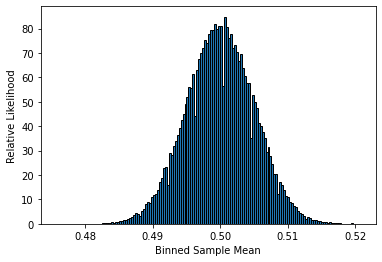

In [32]:
# Visualizing sample means in a histogram
sample_means = frequencies
likelihoods, bin_edges, _ = plt.hist(sample_means, bins="auto", edgecolor="black", density=True)

plt.xlabel("Binned Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

The histogram is shaped like a normal distribution. Let’s calculate the distribution’s
mean and standard deviation.

In [14]:
# Computing the mean and standard deviation of a histogram
mean_normal = np.average(bin_edges[:-1], weights=likelihoods)
var_normal = weighted_variance(bin_edges[:-1], likelihoods)
std_normal = var_normal ** 0.5

print(f"Mean is approximately {mean_normal:.2}")
print(f"Standard deviation is approximately {std_normal:.3f}")

Mean is approximately 0.5
Standard deviation is approximately 0.005


The distribution’s mean is approximately 0.5, and its standard deviation is approximately
0.005. 

In a normal distribution, these values can be computed directly from
the distribution’s peak. We just need the peak’s x-value and y-value coordinates. 

The x-value equals the distribution’s mean, and the standard deviation is equal to the inverse of the y-value multiplied by $(2\pi)^{1/2}$

In [19]:
# Computing mean and standard deviation from peak coordinates
peak_x_value = bin_edges[likelihoods.argmax()]
print(f"Mean is approximately {peak_x_value:.2f}")

peak_y_value = likelihoods.max()
print(f"Max y-value {peak_y_value:.2f}")
std_from_peak = (peak_y_value * (2 * math.pi) ** 0.5) ** -1
print(f"Standard deviation is approximately {std_from_peak:.3f}")

Mean is approximately 0.50
Max y-value 84.85
Standard deviation is approximately 0.005


Additionally, we can compute the mean and standard deviation simply by calling
`stats.norm.fit(sample_means)`. 

This SciPy method returns the two parameters
required to re-create the normal distribution formed by our data.

In [21]:
# Computing mean and standard deviation using stats.norm.fit
fitted_mean, fitted_std = stats.norm.fit(sample_means)
print(f"Mean is approximately {fitted_mean:.2f}")
print(f"Standard deviation is approximately {fitted_std:.3f}")

Mean is approximately 0.50
Standard deviation is approximately 0.005


The computed mean and standard deviation can be used to reproduce our normal
curve. We can regenerate the curve by calling `stats.norm.pdf(bin_edges, fitted_mean, fitted_std)`.

A probability density function is like a probability
mass function but with one key difference: it does not return probabilities.

Instead, it returns relative likelihoods.

As we know, relative likelihoods are the y-axis
values of a curve whose total area equals 1.0. 

Unlike probabilities, these likelihoods
can equal values that are greater than 1.0. 

Despite this, the total area beneath a plotted
likelihood interval still equals the probability of observing a random value within
that interval.

Let’s compute the relative likelihoods using `stats.norm.pdf`.



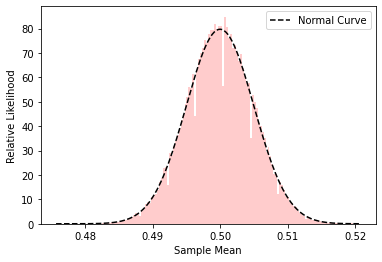

In [22]:
# Computing normal likelihoods using stats.norm.pdf
normal_likelihoods = stats.norm.pdf(bin_edges, fitted_mean, fitted_std)

plt.plot(bin_edges, normal_likelihoods, color="k", linestyle="--", label="Normal Curve")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.legend()
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

The curve’s peak sits at an x-axis position of 0.5 and rises to a y-axis position of approximately 80. As a reminder, the peak’s x and
y coordinates are a direct function of `fitted_mean` and `fitted_std`.

To emphasize this
important relationship, let’s do a simple exercise: we’ll shift the peak 0.01 units to the
right while also doubling the peak’s height.

Well, the peak’s axis is equal to the mean, so we adjust the input mean to `fitted_mean + 0.01`. Also, the peak’s height is inversely proportional to the standard deviation. Therefore,
inputting `fitted_std / 2` should double the height of the peak.



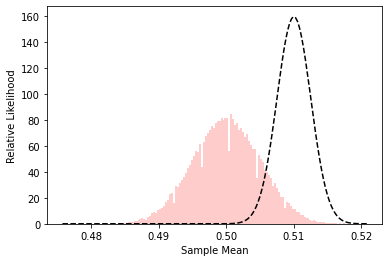

In [24]:
# Manipulating a normal curve’s peak coordinates
adjusted_likelihoods = stats.norm.pdf(bin_edges, fitted_mean + 0.01, fitted_std / 2)

plt.plot(bin_edges, adjusted_likelihoods, color="k", linestyle="--")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

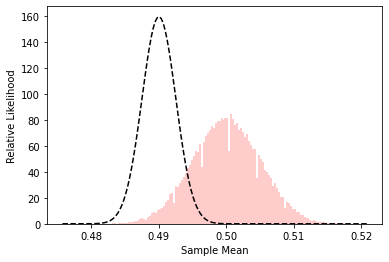

In [34]:
adjusted_likelihoods = stats.norm.pdf(bin_edges, fitted_mean - 0.01, fitted_std / 2)

plt.plot(bin_edges, adjusted_likelihoods, color="k", linestyle="--")
plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

###Comparing two sampled normal curves